In [1]:
import os
import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader

from miniMTL.datasets import caseControlDataset, confDataset
from miniMTL.models import *
from miniMTL.training import Trainer
from miniMTL.hps import HPSModel

/Users/harveyaa/miniconda3/envs/fmri/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define paths to data
p_pheno = os.path.join('/Users/harveyaa/Documents/masters/data/','pheno_26-01-22.csv')
p_ids = '/Users/harveyaa/Documents/masters/neuropsych_mtl/datasets/cv_folds/intrasite/'
p_ids_conf = '/Users/harveyaa/Documents/masters/neuropsych_mtl/datasets/cv_folds/age_sex/'
p_conn = os.path.join('/Users/harveyaa/Documents/masters/data/','connectomes')

In [3]:
# Create datasets
print('Creating datasets...')
cases = ['ASD',
        'SZ',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']
data = []
for case in cases:
    print(case)
    data.append(caseControlDataset(case,p_pheno,id_path=p_ids,conn_path=p_conn,
                                        type='conn',strategy='balanced',format=0))
print('Done!\n')

Creating datasets...
ASD


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


SZ


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


BIP


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


DEL22q11_2


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


DUP22q11_2


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


DEL16p11_2


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


DUP16p11_2


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


DEL1q21_1


/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


DUP1q21_1
Done!



/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:190: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


In [4]:
data_age = confDataset('UKBB11025',p_pheno,conf='AGE',id_path=p_ids_conf,conn_path=p_conn,n_subsamp=500,type='conn')
data_age.name = 'AGE'
data.append(data_age)

/Users/harveyaa/Documents/masters/miniMTL/miniMTL/datasets.py:312: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno = pd.read_csv(pheno_path,index_col=0)


In [5]:
# Split data & create loaders & loss fns
bs = 8

loss_fns = {}
trainloaders = {}
testloaders = {}
decoders = {}
for d, case in zip(data,cases + ['AGE']):
    train_idx, test_idx = d.split_data(random=False,fold=0)
    train_d = Subset(d,train_idx)
    test_d = Subset(d,test_idx)
    trainloaders[case] = DataLoader(train_d, batch_size=bs, shuffle=True)
    testloaders[case] = DataLoader(test_d, batch_size=bs, shuffle=True)
    if case != 'AGE':
        loss_fns[case] = nn.CrossEntropyLoss()
        decoders[case] = eval(f'head{3}().double()')
    else:
        loss_fns[case] = nn.MSELoss()
        decoders[case] = eval(f'head{33}().double()')

In [6]:
# Create model
model = HPSModel(eval(f'encoder{3}().double()'),
                    decoders,
                    loss_fns)

Initialized HPSModel using: cpu.



In [7]:
# Create optimizer & trainer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(optimizer,log_dir='')

In [8]:
# Train model
trainer.fit(model,trainloaders,testloaders,num_epochs=100)

Epoch 99: 100%|██████████| 262/262 [1:54:16<00:00, 26.17s/it]     


In [9]:
# Evaluate at end
metrics = model.score(testloaders)
print(metrics)

{'ASD': {'accuracy': 55.55555555555556, 'loss': 0.653813979580385}, 'SZ': {'accuracy': 74.21875, 'loss': 0.3402351257904599}, 'BIP': {'accuracy': 68.75, 'loss': 0.3467380428305213}, 'DEL22q11_2': {'accuracy': 72.22222222222221, 'loss': 0.2958129666503766}, 'DUP22q11_2': {'accuracy': 77.77777777777779, 'loss': 0.23247258258316825}, 'DEL16p11_2': {'accuracy': 61.53846153846154, 'loss': 0.7337267183569757}, 'DUP16p11_2': {'accuracy': 57.14285714285714, 'loss': 0.7190567740938035}, 'DEL1q21_1': {'accuracy': 40.0, 'loss': 0.9328059291598466}, 'DUP1q21_1': {'accuracy': 50.0, 'loss': 0.6144760775060327}, 'AGE': {'accuracy': 0.0, 'loss': 7.062814278533668}}


In [10]:
metrics

{'ASD': {'accuracy': 55.55555555555556, 'loss': 0.653813979580385},
 'SZ': {'accuracy': 74.21875, 'loss': 0.3402351257904599},
 'BIP': {'accuracy': 68.75, 'loss': 0.3467380428305213},
 'DEL22q11_2': {'accuracy': 72.22222222222221, 'loss': 0.2958129666503766},
 'DUP22q11_2': {'accuracy': 77.77777777777779, 'loss': 0.23247258258316825},
 'DEL16p11_2': {'accuracy': 61.53846153846154, 'loss': 0.7337267183569757},
 'DUP16p11_2': {'accuracy': 57.14285714285714, 'loss': 0.7190567740938035},
 'DEL1q21_1': {'accuracy': 40.0, 'loss': 0.9328059291598466},
 'DUP1q21_1': {'accuracy': 50.0, 'loss': 0.6144760775060327},
 'AGE': {'accuracy': 0.0, 'loss': 7.062814278533668}}

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {'ASD': {'accuracy': 55.55555555555556, 'loss': 0.653813979580385},
 'SZ': {'accuracy': 74.21875, 'loss': 0.3402351257904599},
 'BIP': {'accuracy': 68.75, 'loss': 0.3467380428305213},
 'DEL22q11_2': {'accuracy': 72.22222222222221, 'loss': 0.2958129666503766},
 'DUP22q11_2': {'accuracy': 77.77777777777779, 'loss': 0.23247258258316825},
 'DEL16p11_2': {'accuracy': 61.53846153846154, 'loss': 0.7337267183569757},
 'DUP16p11_2': {'accuracy': 57.14285714285714, 'loss': 0.7190567740938035},
 'DEL1q21_1': {'accuracy': 40.0, 'loss': 0.9328059291598466},
 'DUP1q21_1': {'accuracy': 50.0, 'loss': 0.6144760775060327},
 'AGE': {'accuracy': 0.0, 'loss': 7.062814278533668}}

In [20]:
metrics.keys()

dict_keys(['ASD', 'SZ', 'BIP', 'DEL22q11_2', 'DUP22q11_2', 'DEL16p11_2', 'DUP16p11_2', 'DEL1q21_1', 'DUP1q21_1', 'AGE'])

In [24]:
st = [61.085219, 75.709892, 79.012097, 84.967320, 41.388889, 73.461538, 64.285714, 70.000000, 53.214286]
mtl_no_age = [60.87245, 73.983760, 82.177419, 74.509804, 54.722222, 64.230769, 62.857143, 70.000000, 57.857143]
mtl_age = [55.55555555555556, 74.21875, 68.75, 72.22222222222221, 77.77777777777779, 61.53846153846154, 57.14285714285714, 40.0, 50.0]
cases = ['ASD', 'SZ', 'BIP', 'DEL22q11_2', 'DUP22q11_2', 'DEL16p11_2', 'DUP16p11_2', 'DEL1q21_1', 'DUP1q21_1']

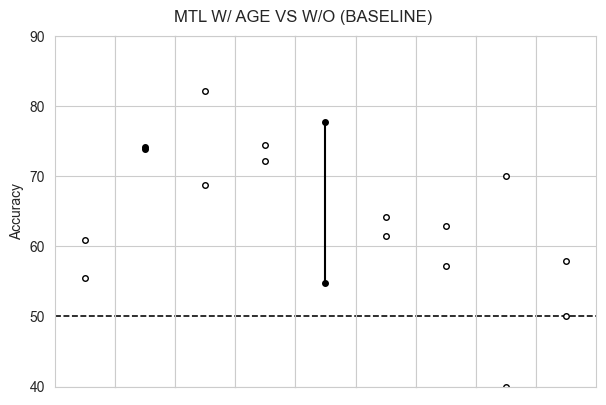

In [27]:
###############
# MTL W/ AGE VS W/O (BASELINE) #
###############
title = 'MTL W/ AGE VS W/O (BASELINE)'
fig,ax = plt.subplots(1,len(cases),figsize=(6,4),sharey=True,sharex=True)
plt.yticks([40,50,60,70,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_acc = mtl_no_age[j]
    mtl_acc = mtl_age[j]
    if st_acc > mtl_acc:
        mfc = 'white'
        ls =''
    else:
        mfc = colors[0]
        ls = '-'

    ax[j].plot(5,mtl_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot(5,st_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    #ax[j].set_xlabel(labels[j],rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[1]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(40,90)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
#plt.savefig(os.path.join(p_intra,'figures/st_vs_mtl.png'),dpi=300)